# Toy 01: measuring appearance & bias

HOWTO: run the dataset & model cells, then run either of the solution cells following by the analysis cell.

In [1]:
%load_ext autoreload

# Dataset

In [2]:
import torch

def mixed_appearance_positions_toy_dataset(size=[6,6]):
    """
    Create a dataset where each image as a single pixel, red or green, and
    left or right of the middle of the screen. In the default training setting,
    each pixel is either red and left, or green and right.
    """
    aligned_images = []
    aligned_labels = []
    cue_app_images = []
    cue_app_labels = []
    cue_pos_images = []
    cue_pos_labels = []
    for app_label, c in enumerate(['red', 'green']):
        for y1 in range(size[0]):
            for x1 in range(size[1]):
                image = torch.rand([3] + size) * 0.0
                image[app_label, y1, x1] = 1.0

                if x1 < size[1] // 2:
                    pos_label = 0
                else:
                    pos_label = 1

                if app_label == pos_label:
                    aligned_images.append(image)
                    aligned_labels.append(app_label)
                else:
                    cue_app_images.append(image)
                    cue_app_labels.append(app_label)
                    cue_pos_images.append(image)
                    cue_pos_labels.append(pos_label)

    aligned_images = torch.stack(aligned_images)
    aligned_labels = torch.tensor(aligned_labels, dtype=torch.long)
    cue_app_images = torch.stack(cue_app_images)
    cue_app_labels = torch.tensor(cue_app_labels, dtype=torch.long)
    cue_pos_images = torch.stack(cue_pos_images)
    cue_pos_labels = torch.tensor(cue_pos_labels, dtype=torch.long)

    return aligned_images, aligned_labels, cue_app_images, cue_app_labels, cue_pos_images, cue_pos_labels

size = [6, 6]
images, labels, cue_app_images, cue_app_labels, cue_pos_images, cue_pos_labels = mixed_appearance_positions_toy_dataset(size=size)

In [3]:
# train_split = (0.0, 0.9)
# test_split = (0.9, 1.0)
train_split = (0.0, 1.0)
test_split = (0.0, 1.0)

indices = torch.randperm(images.shape[0])
train_indices = indices[int(train_split[0] * indices.shape[0]):int(train_split[1] * indices.shape[0])]
test_indices = indices[int(test_split[0] * indices.shape[0]):int(test_split[1] * indices.shape[0])]
train_images = images[train_indices]
train_labels = labels[train_indices]
test_images = images[test_indices]
test_labels = labels[test_indices]
analysis_images = images
analysis_labels = labels

print(f"{train_images.shape[0]} training samples")
print(f"{test_images.shape[0]} test samples")
print(f"{analysis_images.shape[0]} analysis samples")
print(f"{cue_app_images.shape[0]} cue_app samples")
print(f"{cue_pos_images.shape[0]} cue_pos samples")

36 training samples
36 test samples
36 analysis samples
36 cue_app samples
36 cue_pos samples


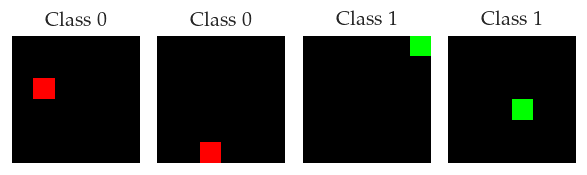

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axs = plt.subplots(1, 4, figsize=(1 + 2 * 2, 2), dpi=120)
j = 0
for c in range(2):
    for i in range(2):
        inds = train_labels == c
        axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[j].set_title(f"Class {train_labels[inds][i]}")
        axs[j].axis('off')
        j += 1

plt.tight_layout()
pass

# Model

In [5]:
%autoreload

from torch import nn
import ml_collections

import sys
sys.path.append('..')

from models.vit_modeling import Block

def block_config(d=4):
    """Returns the vit configuration for the cifar dataset"""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (1, 1)})
    config.hidden_size = d
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = d
    config.transformer.num_heads = 1
    # config.transformer.num_heads = 2
    config.transformer.num_layers = 1
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.0
    return config

class TriViTal(nn.Module):
    def __init__(self, d=4, handcrafted_weights=None, pool='avg', norm=True, residual=True, pos_emb='absolute', use_rel_pos=True):
        super().__init__()
        self.patch_layer = nn.Conv2d(3, d, kernel_size=1, padding=0)
        if pos_emb == 'absolute':
            self.pos_embedding = nn.Parameter(torch.randn(1, d, 6, 6) * 0.1)
        elif pos_emb == 'none':
            # self.pos_embedding = torch.zeros(1, d, 5, 5)
            self.pos_embedding = None
        # self.pos_embedding = nn.Parameter(torch.zeros(1, d, 5, 5))
        # self.pos_embedding.requires_grad_(False)
        # self.block1 = Block(block_config(d), True, None, False, False, override_attn_out_dim=2)
        self.block1 = Block(config=block_config(d), img_size=(6, 6), use_rel_pos=use_rel_pos, compute_gradbased_attr=True, norm=norm, residual=residual)
        if pool == 'avg':
            self.pool = nn.AdaptiveAvgPool1d([1])
        elif pool == 'max':
            self.pool = nn.AdaptiveMaxPool1d([1])
        else:
            raise ValueError(f"Unknown pooling type: {pool}")
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(d, 2)

        self.image_in = None
        self.pos_emb_in = None
        self.attn_probs = None
        self.attn_out = None
        self.attn_probs_sliced = []

        if handcrafted_weights is not None:
            params = dict(self.named_parameters())
            training = {n: True for n in params.keys()}
            for name, param in handcrafted_weights.items():
                params[name].data = handcrafted_weights[name]
                training[name] = False

            # print('\nTraining:')
            # for name in training:
            #     print(f"{name}: {training[name]}")

            if all([not training[name] for name in params]):
                print('\nNo parameters to train!')

    def forward(self, x):
        self.image_in = x
        self.image_in.requires_grad = True
        self.image_in.retain_grad()

        def to_attn_format(data):
            return data.permute((0, 2, 3, 1)).view(data.shape[0], -1, data.shape[1])
        def from_attn_format(data):
            return data.permute([0, 2, 1])

        out_sem = self.patch_layer(x)
        self.patch_activations = out_sem
        out_pos = self.pos_embedding
        self.pos_emb_in = out_pos
        if self.pos_embedding is not None:
            out = out_sem + out_pos
        else:
            out = out_sem
        self.token_activations = out

        out = to_attn_format(out)
        out, self.attn_probs, self.attn_probs_sliced = self.block1(out)

        # To make feature maps differentiable *per sample* we
        # need to include the slicing per sample in the graph. Otherwise
        # autograd.grad() complains that the sliced tensors are not in the
        # graph when we later compute the image/position attributions wrt
        # the feature map.
        self.attn_out_sliced = []
        # Shape of feature map: [batch_size, tokens, channels]
        B, D, C = out.shape
        for i in range(B):
            # What we want: first dimension should be [num_heads], so
            # autograd.grad() can compute the "batched" vector-Jacobian for each
            # head, as we will use the "batched" mode of grad() where the first
            # dimension needs to contain the "batches".
            num_heads = self.block1.attn.num_attention_heads
            grad_compat_slice = out[i].permute((1, 0)).reshape(num_heads, -1, D)
            grad_compat_slice.retain_grad()
            self.attn_out_sliced.append(grad_compat_slice)
        out = torch.stack(self.attn_out_sliced).reshape(B, C, D).permute((0, 2, 1))

        out = from_attn_format(out)

        out = self.pool(out)
        out = self.flatten(out)
        out = self.fc(out)

        return out

/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


# Training

In [6]:
%autoreload
import numpy as np

import training
import utils


def run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=250, attribution_method='input_gradient_withnegative'):
    biases = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
    biases_withbias = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
    cls_biases = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
    cls_biases_withbias = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
    for seed in seeds:
        torch.manual_seed(seed)
        model = TriViTal(d=d, use_rel_pos=use_rel_pos, pos_emb=pos_emb)
        training.train_toy(model, train_images, train_labels, test_images, test_labels, epochs=n_epochs, report_every_n=report_every_n, batch_size=128, lr=lr)

        # Test app/pos cue test sets
        print(f"Non-aligned test set, appearance labels:")
        training.test_toy(model, cue_app_images, cue_app_labels, batch_size=128)
        print(f"Non-aligned test set, position labels:")
        training.test_toy(model, cue_pos_images, cue_pos_labels, batch_size=128)

        sources_available = ['image', 'bias']
        if pos_emb != 'none':
            sources_available.append('pos_emb')
        if use_rel_pos:
            sources_available.append('relpos')
        seed_biases, seed_biases_withbias, seed_cls_biases, seed_cls_biases_withbias = \
            utils.toy_all_analyses(model, analysis_images, analysis_labels, n_classes, seed, sources_available=sources_available, attribution_method=attribution_method)

        for key in seed_biases:
            biases[key].append(seed_biases[key])
            for c in range(n_classes):
                cls_biases[c][key].append(seed_cls_biases[c][key])

        for key in seed_biases_withbias:
            biases_withbias[key].append(seed_biases_withbias[key])
            for c in range(n_classes):
                cls_biases_withbias[c][key].append(seed_cls_biases_withbias[c][key])

    utils.toy_postprocess_analysis(biases, biases_withbias, cls_biases, cls_biases_withbias, seeds, n_classes, sort_by_appearance=True)

### No PE with negative

In [12]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# DEBUG
# seeds = range(2)
# n_epochs = 1000
# pos_emb = 'none'
# use_rel_pos = False

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7228641510009766
Epoch 2000: 0.03409751132130623
Epoch 3999: 0.004547501914203167
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7214401960372925
Epoch 2000: 0.03386129438877106
Epoch 3999: 0.004512425512075424
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7209898233413696
Epoch 2000: 0.03826826438307762
Epoch 3999: 0.00484891701489687
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.0251182317733765
Epoch 2000: 0.059072740375995636
Epoch 3999: 0.006616562604904175
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7439985871315002
Epoch 2000: 0.04098527133464813
Epoch 3999: 0.005090431310236454
Accuracy: 1.0
Non-aligned test set, appearance 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### No PE

In [7]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# DEBUG
# seeds = range(2)
# n_epochs = 1000
# pos_emb = 'none'
# use_rel_pos = False

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.722864031791687


Epoch 2000: 0.03409676253795624
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7214401960372925
Epoch 2000: 0.03386266902089119
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7209898829460144
Epoch 2000: 0.038272175937891006
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.0251182317733765
Epoch 2000: 0.059072647243738174
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7439985871315002
Epoch 2000: 0.04098393768072128
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.9618125557899475
Epoch 2000: 0.04755457863211632
Accuracy: 1.0
Non-aligned test set, appearance labels:
A

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### APE - fix zero grad

In [8]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.828748345375061
Epoch 2000: 0.0465080663561821
Epoch 3999: 0.005591819528490305
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.6942115426063538
Epoch 2000: 0.033384084701538086
Epoch 3999: 0.004492768552154303
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.836731493473053
Epoch 2000: 0.04200611636042595
Epoch 3999: 0.005170801654458046
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.8041321635246277
Epoch 2000: 0.042837027460336685
Epoch 3999: 0.005211748648434877
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7416418790817261
Epoch 2000: 0.035236671566963196
Epoch 3999: 0.004636865574866533
Accuracy: 1.0
Non-aligned test set, appearance 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### APE with negative

In [13]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.828748345375061
Epoch 2000: 0.04650859907269478
Epoch 3999: 0.005591769702732563
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()


Epoch 0: 0.6942115426063538
Epoch 2000: 0.0333838015794754
Epoch 3999: 0.004492695908993483
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.8367314338684082
Epoch 2000: 0.04200518876314163
Epoch 3999: 0.005170703399926424
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.8041320443153381
Epoch 2000: 0.04283669963479042
Epoch 3999: 0.005211785435676575
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7416418790817261
Epoch 2000: 0.03523640334606171
Epoch 3999: 0.004636790137737989
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7042528986930847
Epoch 2000: 0.03521597757935524
Epoch 3999: 0.004639219027012587
Accuracy: 1.0
Non-aligned test set, appearance l

### APE

In [8]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.8287484049797058


Epoch 2000: 0.04650852829217911
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.6942115426063538
Epoch 2000: 0.033384159207344055
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.836731493473053
Epoch 2000: 0.04200572520494461
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.8041321635246277
Epoch 2000: 0.042837128043174744
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7416418194770813
Epoch 2000: 0.0352364219725132
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7042529582977295
Epoch 2000: 0.03521618992090225
Accuracy: 1.0
Non-aligned test set, appearance labels:
Acc

### RPE - fix zero grad

In [9]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7114745378494263
Epoch 2000: 0.033318016678094864
Epoch 3999: 0.004472550470381975
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.6938590407371521
Epoch 2000: 0.03308118134737015
Epoch 3999: 0.00445528281852603
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.173471212387085
Epoch 2000: 0.06399813294410706
Epoch 3999: 0.007004056591540575
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7363043427467346
Epoch 2000: 0.039210688322782516
Epoch 3999: 0.0049342205747962
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7936512231826782
Epoch 2000: 0.04207032173871994
Epoch 3999: 0.005192108917981386
Accuracy: 1.0
Non-aligned test set, appearance la

### RPE with negative

In [14]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7114745378494263
Epoch 2000: 0.033318016678094864
Epoch 3999: 0.004472431261092424
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.6938591003417969
Epoch 2000: 0.03308119252324104
Epoch 3999: 0.004455460701137781
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.173471212387085
Epoch 2000: 0.06399640440940857
Epoch 3999: 0.007003601174801588
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7363044023513794
Epoch 2000: 0.039205923676490784
Epoch 3999: 0.0049347709864377975
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7936512231826782
Epoch 2000: 0.042071714997291565
Epoch 3999: 0.005191641394048929
Accuracy: 1.0
Non-aligned test set, appearan

### RPE

In [9]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.7114745378494263


Epoch 2000: 0.03331971541047096
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.6938591599464417
Epoch 2000: 0.0330813005566597
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.173471212387085
Epoch 2000: 0.06399931758642197
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7363044023513794
Epoch 2000: 0.03920909762382507
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.793651282787323
Epoch 2000: 0.04207083210349083
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.9012516736984253
Epoch 2000: 0.05142853781580925
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accura

### APE+RPE - fix zero grad

In [10]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7047650814056396
Epoch 2000: 0.03388640284538269
Epoch 3999: 0.00451518502086401
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7585505843162537
Epoch 2000: 0.0380822978913784
Epoch 3999: 0.004880568943917751
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7214601039886475
Epoch 2000: 0.03396514430642128
Epoch 3999: 0.0044984351843595505
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.2208027839660645
Epoch 2000: 0.06195826083421707
Epoch 3999: 0.006809977814555168
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7620532512664795
Epoch 2000: 0.03620481863617897
Epoch 3999: 0.004688028711825609
Accuracy: 1.0
Non-aligned test set, appearance l

### APE+RPE with negative

In [15]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7047650814056396
Epoch 2000: 0.03388608247041702
Epoch 3999: 0.0045152571983635426
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7585506439208984
Epoch 2000: 0.038082681596279144
Epoch 3999: 0.004880621563643217
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7214601039886475
Epoch 2000: 0.03396492823958397
Epoch 3999: 0.00449844216927886
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.220802664756775
Epoch 2000: 0.06195751950144768
Epoch 3999: 0.006810008082538843
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7620532512664795
Epoch 2000: 0.03620503097772598
Epoch 3999: 0.004687999375164509
Accuracy: 1.0
Non-aligned test set, appearance 

### APE + RPE

In [10]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

run_mixed(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.7047650814056396


Epoch 2000: 0.03388597443699837
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7585506439208984
Epoch 2000: 0.03808280825614929
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7214601039886475
Epoch 2000: 0.0339650996029377
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 1.220802664756775
Epoch 2000: 0.061958491802215576
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.7620533108711243
Epoch 2000: 0.03620484098792076
Accuracy: 1.0
Non-aligned test set, appearance labels:
Accuracy: 1.0
Non-aligned test set, position labels:
Accuracy: 0.0
Epoch 0: 0.9600737690925598
Epoch 2000: 0.055505797266960144
Accuracy: 1.0
Non-aligned test set, appearance labels:
Acc